In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import imp
import matplotlib.pyplot as plt
import xgboost
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
%matplotlib inline
from HelperClass.DataProcessing import *
from HelperClass.NN_Model import build_model

In [3]:
trainDataFile = 'Data/train.csv'
testDataFile = 'Data/test.csv'
dataTypes = {
    'PassengerId' : 'int64',
    'Survived' : 'int64',
    'Pclass' : 'int64',
    'Name' : 'object',
    'Sex' : 'object',
    'Age' : 'float64',
    'SibSp' : 'int64',
    'Parch' : 'int64',
    'Ticket' : 'object',
    'Fare' : 'float64',
    'Cabin' : 'object',
    'Embarked' : 'object'
}
sep = ','
target = 'Survived'
clusterIdCol = 'PassagerClusterId'
randomSeed = 83213
testRatio = 0.20
numCores = 7

## Reading data

In [4]:
dataProc = DataProcessing(trainDataFile, dataTypes, sep)
dataProc.ReadFile()
### Here we remove nulls since there were only 2 records that has null in the field
dataProc.AllData = dataProc.AllData[~dataProc.AllData.Embarked.isnull()]

submitDataProc = DataProcessing(testDataFile, dataTypes, sep)
submitDataProc.ReadFile()

Findings
1. Age makes difference, F_onewayResult(statistic=4.271194933815904, pvalue=0.03912465401348333)
2. Fare makes difference, F_onewayResult(statistic=63.03076422804448, pvalue=6.120189341921873e-15)
3. PassengerId doesn't make difference, F_onewayResult(statistic=0.022284812266068058, pvalue=0.8813657768798144)
4. Pclass makes difference, F_onewayResult(statistic=115.03127218827665, pvalue=2.5370473879805644e-25)
5. SibSp doesn't make difference, F_onewayResult(statistic=1.110572204113227, pvalue=0.29224392869817906)
6. Parch makes difference, F_onewayResult(statistic=5.963463836603541, pvalue=0.0147992453747224)

## Feature generation and encoding

In [5]:
def PopulateFeatures(data):
    data.Cabin.fillna('NA', inplace=True)
    data['CabinType'] = data.Cabin.fillna('NA').str.get(0)
    return data

In [6]:
dataProc.AllData = PopulateFeatures(dataProc.AllData)
submitDataProc.AllData = PopulateFeatures(submitDataProc.AllData)

In [7]:
dataProc.AllData['CabinType_B_D_E'] = np.where(dataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)
submitDataProc.AllData['CabinType_B_D_E'] = np.where(submitDataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)

In [8]:
dataProc.AllData.Age.fillna(-999, inplace=True)
submitDataProc.AllData.Age.fillna(-999, inplace=True)

In [9]:
bins = [-10000, 0, 20, 60, 1000]
dataProc.AllData['AgeGroup'] = pd.cut(dataProc.AllData.Age, bins).astype(str)
submitDataProc.AllData['AgeGroup'] = pd.cut(submitDataProc.AllData.Age, bins).astype(str)

In [10]:
dataProc.AllData['GenderAgeGroup'] = dataProc.AllData.Sex + '_' + dataProc.AllData.AgeGroup
submitDataProc.AllData['GenderAgeGroup'] = submitDataProc.AllData.Sex + '_' + submitDataProc.AllData.AgeGroup

In [11]:
dataProc.AllData.groupby(['GenderAgeGroup']).agg({'Survived' : ['mean', 'count']}).sort_values(by=('Survived', 'mean'), 
                                                                                               ascending=False)

Survived      
                        mean count
GenderAgeGroup                    
female_(60, 1000]   1.000000     2
female_(20, 60]     0.777778   180
female_(0, 20]      0.688312    77
female_(-10000, 0]  0.679245    53
male_(0, 20]        0.284314   102
male_(20, 60]       0.186747   332
male_(-10000, 0]    0.129032   124
male_(60, 1000]     0.105263    19

In [12]:
genderAgeGroups = {
    'GenderAgeGroup' : {
        'female_(20, 60]' : 7, 
        'female_(60, 1000]' : 8,
        'female_(0, 20]' : 6, 
        'female_(-10000, 0]' : 5,
        'male_(0, 20]' : 4, 
        'male_(20, 60]' : 3, 
        'male_(-10000, 0]' : 2, 
        'male_(60, 1000]' : 1
    }
}

In [13]:
dataProc.AllData.replace(genderAgeGroups, inplace=True)
submitDataProc.AllData.replace(genderAgeGroups, inplace=True)

In [14]:
dataProc.AllData['Sex'] = np.where(dataProc.AllData['Sex'] == 'male', 1, 2)
submitDataProc.AllData['Sex'] = np.where(submitDataProc.AllData['Sex'] == 'male', 1, 2)

In [15]:
embarkedEncoding = {
    'Embarked' : {
       'S' : 1,
       'Q' : 1,
       'C' : 2
    }
}

In [16]:
dataProc.AllData.replace(embarkedEncoding, inplace=True)
submitDataProc.AllData.replace(embarkedEncoding, inplace=True)

In [17]:
numCols = ['Fare', 'Pclass', 'Parch', 'CabinType_B_D_E', 'GenderAgeGroup', 'Embarked', 'Sex']

## Use clustering approach to group passagers

In [18]:
columnsToFindCluster = ['Pclass', 'GenderAgeGroup', 'Parch']

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainingCopy = dataProc.AllData[columnsToFindCluster]
trainingCopy = scaler.fit_transform(trainingCopy)
submitDataCopy = scaler.transform(submitDataProc.AllData[columnsToFindCluster])

In [20]:
trainingCopy[:, 0] = trainingCopy[:, 0] * 10
trainingCopy[:, 1] = trainingCopy[:, 1] * 5
trainingCopy[:, 2] = trainingCopy[:, 2]  

submitDataCopy[:, 0] = submitDataCopy[:, 0] * 10
submitDataCopy[:, 1] = submitDataCopy[:, 1] * 5
submitDataCopy[:, 2] = submitDataCopy[:, 2]

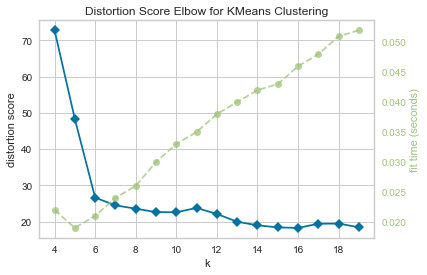

In [21]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,20))
visualizer.fit(trainingCopy) 
visualizer.poof()

In [22]:
kmeans = KMeans(n_clusters=6, random_state=randomSeed).fit(trainingCopy)

In [23]:
numCols.append(clusterIdCol)

In [ ]:
dataProc.AllData[clusterIdCol] = kmeans.labels_.astype(str)

In [ ]:
dataProc.AllData.groupby([clusterIdCol])[target].mean().sort_values()

PassagerClusterId
4    0.135447
0    0.157407
3    0.368852
1    0.500000
5    0.921053
2    0.967391
Name: Survived, dtype: float64

In [ ]:
submitDataProc.AllData[clusterIdCol] = kmeans.predict(submitDataCopy).astype(str)

In [ ]:
submitDataProc.AllData[submitDataProc.AllData.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinType,CabinType_B_D_E,AgeGroup,GenderAgeGroup,PassagerClusterId
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,NA,1,N,1,"(60, 1000]",1,4


In [ ]:
averageFare = submitDataProc.AllData[submitDataProc.AllData.PassagerClusterId == '4'].Fare.mean()
submitDataProc.AllData.Fare.fillna(averageFare, inplace=True)

In [ ]:
clusterMapping = {
    clusterIdCol : {
        '4' : 1,
        '0' : 1,
        '3' : 2,
        '1' : 4,
        '5' : 6,
        '2' : 6,
    }
}

In [ ]:
dataProc.AllData.replace(clusterMapping, inplace=True)
submitDataProc.AllData.replace(clusterMapping, inplace=True)

In [ ]:
dataProc.PopulateFeatureColumns(numCols)
submitDataProc.PopulateFeatureColumns(numCols)

In [ ]:
dataProc.y = dataProc.AllData[target]

In [ ]:
dataProc.RandomSplitTrainTestData(testRatio, randomSeed, True)

In [ ]:
dataProc.X.dtypes

Fare                 float64
Pclass                 int64
Parch                  int64
CabinType_B_D_E        int32
GenderAgeGroup         int64
Embarked               int64
Sex                    int32
PassagerClusterId      int64
dtype: object

In [ ]:
preProc = ColumnTransformer([
    ('StdScaler', StandardScaler(), numCols)
])

## Random forest model

In [ ]:
rf = RandomForestClassifier(random_state = randomSeed, n_jobs=numCores)
rfpipeline = Pipeline([('preProc', preProc),
                       ('poly', PolynomialFeatures()),
                       #('ReduceDim', SelectKBest(f_classif)),
                       ('rf', rf)])
params = {
    'poly__degree' : [1, 2],
    'rf__n_estimators' : range(10, 20),
    'rf__max_depth' : range(1, 5),
    'rf__max_features' : ['sqrt', 'log2', None]
}
rfcv = RandomizedSearchCV(rfpipeline, n_iter= 100, scoring = 'accuracy', 
                          param_distributions=params, verbose=1, cv = 5, random_state=randomSeed)

In [ ]:
#rfcv.fit(dataProc.X_train, dataProc.y_train)

In [ ]:
#rfcv.best_params_

In [ ]:
#y_train_stacking_pred = rfcv.predict(dataProc.X_train)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = rfcv.predict(dataProc.X_test)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## XGB model

In [ ]:
param_grid = {
    'poly__degree' : [1, 2],
    'xgb__max_depth' : [3, 4, 5, 6],
    'xgb__learning_rate' : [0.05, 0.1, 0.2],
    'xgb__n_estimators' : range(5, 21),
    'xgb__subsample' : [0.8, 0.9, 0.95],
    'xgb__colsample_bytree' : [0.8, 0.9, 0.95],
    'xgb__reg_alpha' : [0.05, 0.1, 0.2, 0.4],
    'xgb__reg_lambda' : [0.05, 0.1, 0.2, 0.4],
    'xgb__gamma' : [0.0001, 0.001, 0.01, 0.1]
}

xgb = xgboost.XGBClassifier(seed=randomSeed, n_jobs=numCores)
xgbpipeline = Pipeline([('preProc', preProc),
                        ('poly', PolynomialFeatures()),
                        ('xgb', xgb)])
xgbcv = RandomizedSearchCV(xgbpipeline, n_iter = 1000, cv=5, param_distributions =param_grid, 
                           scoring='accuracy', verbose = 1, random_state=randomSeed)

In [ ]:
#xgbcv.fit(dataProc.X_train, dataProc.y_train)

In [ ]:
#xgbcv.best_params_

In [ ]:
#y_train_stacking_pred = xgbcv.predict(dataProc.X_train)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = xgbcv.predict(dataProc.X_test)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {
    'ada__learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
    'ada__n_estimators' : range(5, 150)
}
ada = AdaBoostClassifier(random_state=randomSeed)
adapipeline = Pipeline([('ada', ada)])
adacv = RandomizedSearchCV(adapipeline, n_iter = 500, cv=5, param_distributions =param_grid,
                           scoring='accuracy', verbose = 1, random_state=randomSeed)

In [ ]:
#adacv.fit(dataProc.X_train, dataProc.y_train)

In [ ]:
#adacv.best_params_

In [ ]:
#y_train_stacking_pred = adacv.predict(dataProc.X_train)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = adacv.predict(dataProc.X_test)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## Logistic regression

In [ ]:
from sklearn import linear_model
param_grid = {
    'poly__degree' : [1, 2, 3],
    'lr__penalty' : ['l1', 'l2'],
    'lr__C' : np.logspace(0, 4, 10),
    'lr__solver' : ['liblinear', 'saga']
}

logistic = linear_model.LogisticRegression(n_jobs = numCores)
logisticPipeline = Pipeline([('preProc', preProc),
                             ('poly', PolynomialFeatures()), 
                             ('lr', logistic)])
logisticCV = GridSearchCV(logisticPipeline, param_grid, cv=5, verbose=1) 

In [ ]:
#logisticCV.fit(dataProc.X_train, dataProc.y_train)

In [ ]:
#logisticCV.best_params_

In [ ]:
#y_train_stacking_pred = logisticCV.predict(dataProc.X_train)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))
#
#y_test_stacking_pred = logisticCV.predict(dataProc.X_test)
#print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

## Model stacking

In [ ]:
from mlens.ensemble import SuperLearner
ensemble = SuperLearner(scorer=accuracy_score, random_state=randomSeed, folds = 5, verbose = 1, n_jobs = numCores)
estimators = [rfcv, xgbcv, adacv]
ensemble.add(estimators, proba=True)
ensemble.add_meta(logisticCV)

[MLENS] backend: threading


SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4761, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...D1EE6A8>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=83213, sample_size=20,
       scorer=<function accuracy_score at 0x0000020DAD1EE6A8>,
       shuffle=False, verbose=1)

In [ ]:
ensemble.fit(dataProc.X_train, dataProc.y_train)


Fitting 2 layers
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fitsFitting 5 folds for each of 100 candidates, totalling 500 fits

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.5min finished


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
y_train_stacking_pred = ensemble.predict(dataProc.X_train)
print('Stacking %.3f ' % accuracy_score(dataProc.y_train, y_train_stacking_pred))

In [ ]:
y_test_stacking_pred = ensemble.predict(dataProc.X_test)
print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

In [ ]:
submitDataProc.AllData[target] = ensemble.predict(submitDataProc.X.reindex(columns=numCols)).astype('int')
submitDataProc.AllData[['PassengerId', 'Survived']].to_csv('submit.txt', index=False)